In [0]:
from delta.tables import DeltaTable

listing_delta = DeltaTable.forName(spark, "airbnb.raw.listings")
listing_df = listing_delta.toDF()


In [0]:
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
import pandas as pd

def missing_stats(df: DataFrame) -> pd.DataFrame:
    """
    Повертає pandas DataFrame зі статистикою пропусків по колонках.
    Використовує isnan тільки для числових колонок.
    """
    total_rows = df.count()
    exprs = []
    
    for c, t in df.dtypes:
        if t in ('double', 'float'):
            exprs.append(F.count(F.when(F.col(c).isNull() | F.isnan(c), c)).alias(c))
        else:
            exprs.append(F.count(F.when(F.col(c).isNull(), c)).alias(c))
    
    stats_df = df.select(exprs).toPandas().T.reset_index()
    stats_df.columns = ["column", "missing_count"]
    stats_df["missing_percent"] = (stats_df["missing_count"] / total_rows) * 100
    stats_df = stats_df.sort_values("missing_percent", ascending=False)
    
    return stats_df


def missing_by_row(df: DataFrame) -> pd.DataFrame:
    """
    Повертає pandas DataFrame з кількістю пропусків по рядках.
    """
    row_missing = df.withColumn("missing_count",
                                sum(F.when(F.col(c).isNull() | F.isnan(c), 1).otherwise(0) 
                                    for c in df.columns))
    return row_missing.select("missing_count").toPandas()


In [0]:

stats = missing_stats(listing_df)
stats_spark = spark.createDataFrame(stats)
stats_spark.write.mode("overwrite").saveAsTable("monitoring.missing_stats_airbnb")
display(stats)  


column,missing_count,missing_percent
calendar_updated,90685,100.0
bathrooms,90685,100.0
neighbourhood_group_cleansed,90685,100.0
host_neighbourhood,43281,47.72674642994983
host_about,43029,47.44886144345812
neighborhood_overview,34153,37.661134697028174
neighbourhood,34153,37.661134697028174
host_location,24983,27.54920879969124
review_scores_value,13804,15.221922037823235
review_scores_checkin,13790,15.20648398301814


/home/spark-a3412f06-88fe-43c9-9dcf-ed/.ipykernel/2449/command-1242831895003042-381482612:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="column", y="missing_percent", data=stats_df, palette="Reds_r")


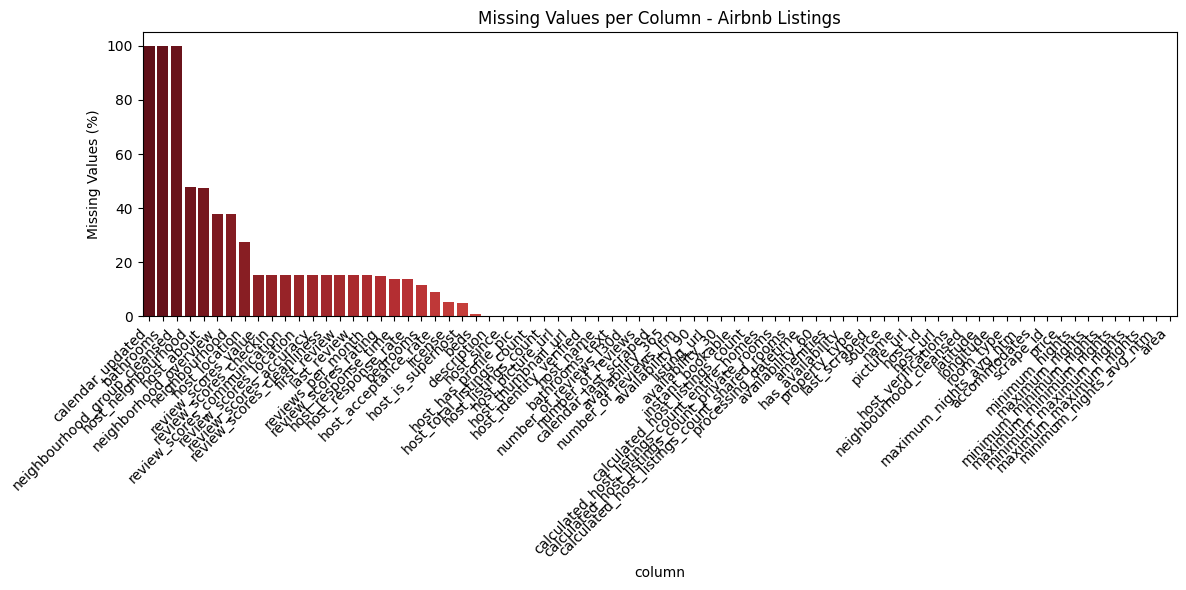

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing(stats_df):
    plt.figure(figsize=(12,6))
    sns.barplot(x="column", y="missing_percent", data=stats_df, palette="Reds_r")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Missing Values (%)")
    plt.title("Missing Values per Column - Airbnb Listings")
    plt.tight_layout()
    plt.show()

plot_missing(stats)
